In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pylab import rcParams

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [164]:
rcParams['figure.figsize'] = 15, 6

In [165]:
path_matlab = "../../data/series/series_matlab.csv"
path_fires = "../../data/series/series_fires_acre.csv"

series_matlab = pd.read_csv(path_matlab)
series_fires = pd.read_csv(path_fires, encoding='ISO-8859-1')

# Series Fires

In [166]:
series_fires

,date,number
0,1998-01-01,0.000
1,1998-02-01,0.000
2,1998-03-01,0.000
3,1998-04-01,0.000
4,1998-05-01,0.000
...,...,...
234,2017-07-01,457.000
235,2017-08-01,1.493
236,2017-09-01,3.429
237,2017-10-01,1.508


In [167]:
series_fires['date'] = pd.to_datetime(series_fires['date'])

In [168]:
series_fires = series_fires.set_index('date')

<Axes: xlabel='date'>

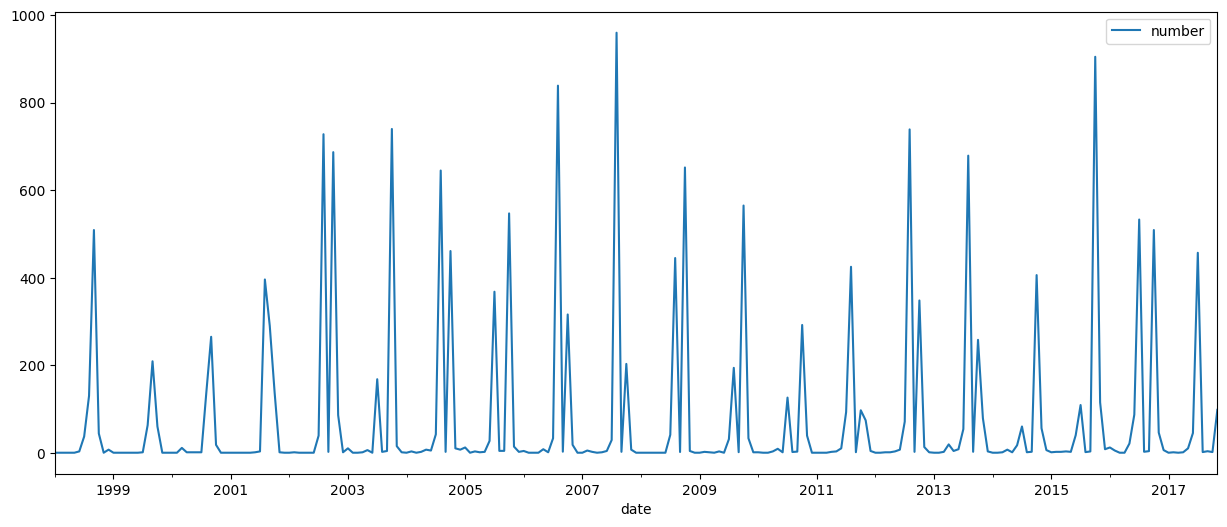

In [169]:
series_fires.plot()

In [170]:
train_fires, val_fires, test_fires = series_fires.loc['1998':'2013'], series_fires.loc['2014':'2015'], series_fires.loc['2016':'2017']

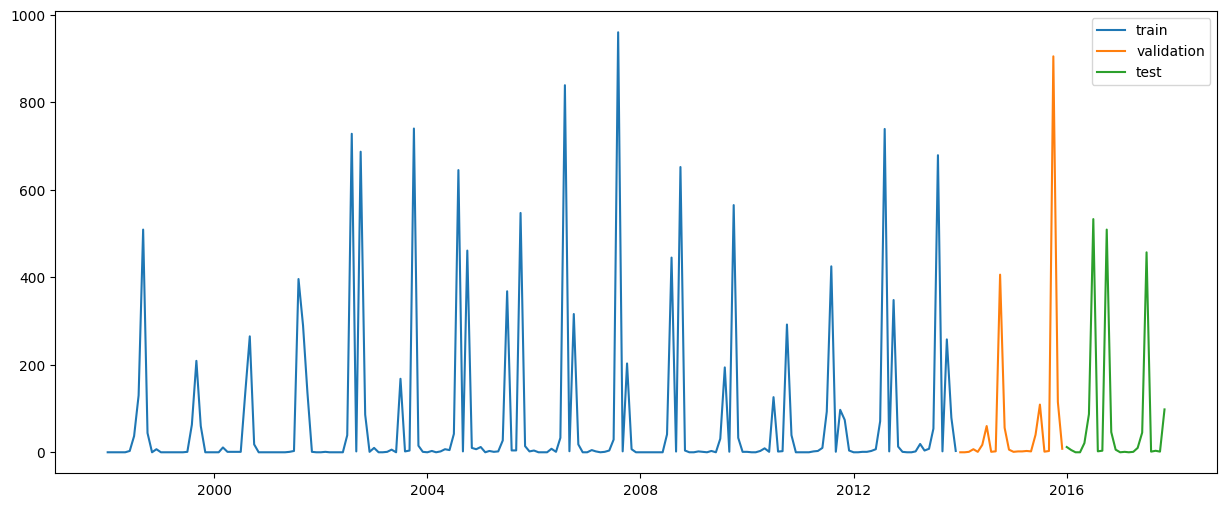

In [171]:
plt.plot(train_fires, label = 'train')
plt.plot(val_fires, label = 'validation')
plt.plot(test_fires, label = 'test')
plt.legend(loc = 'best')
plt.show()

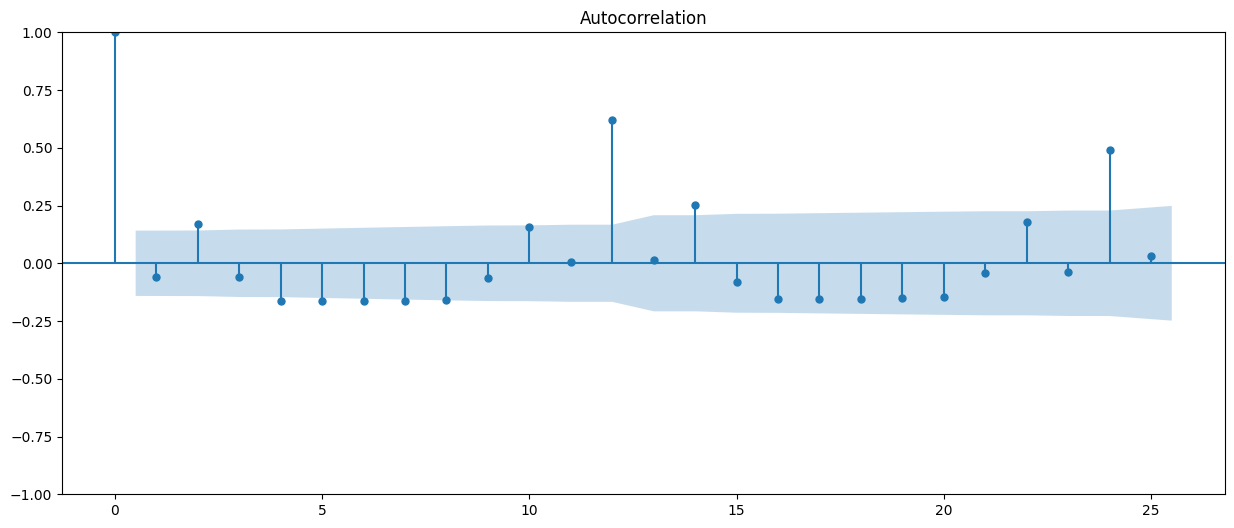

In [172]:
sm.graphics.tsa.plot_acf(train_fires, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


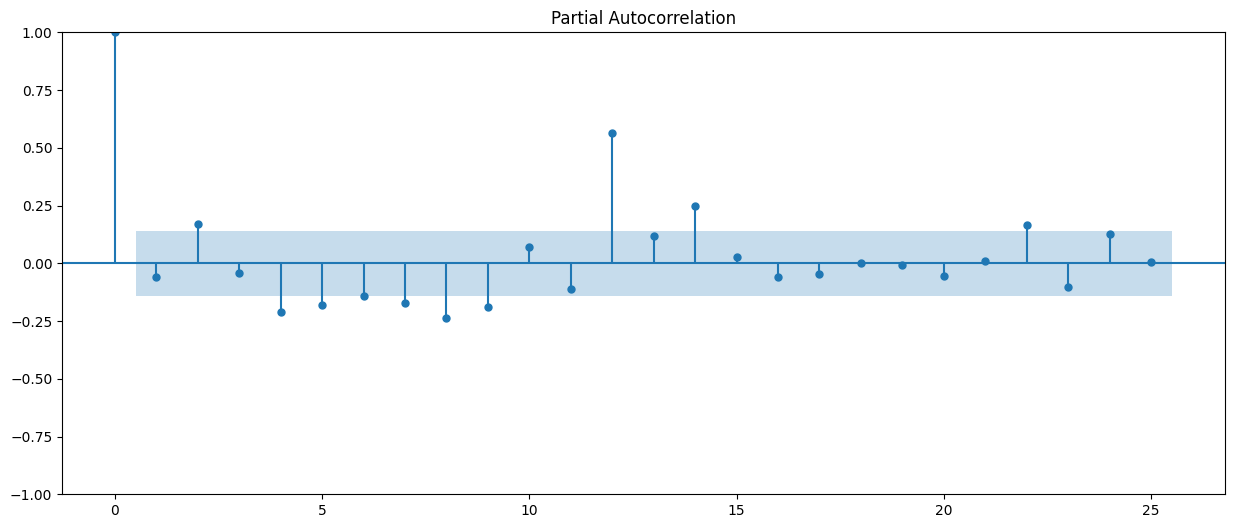

In [173]:
fig = sm.graphics.tsa.plot_pacf(train_fires, lags=25)
plt.show()

In [174]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [175]:
train_windows = create_sliding_windows(train_fires, 12)
val_windows = create_sliding_windows(val_fires, 12)
test_windows = create_sliding_windows(test_fires, 12)

In [176]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [177]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']


best_mse = np.inf
best_criterion = None
best_splitter = None

for c in criterion:
  for s in splitter:
    modelo = DecisionTreeRegressor(criterion=c, splitter=s)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse = MSE(y_val, prev_val)
    if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s

In [178]:
(best_criterion, best_splitter, best_mse)

('absolute_error', 'random', 27294.2216015)

In [179]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [180]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

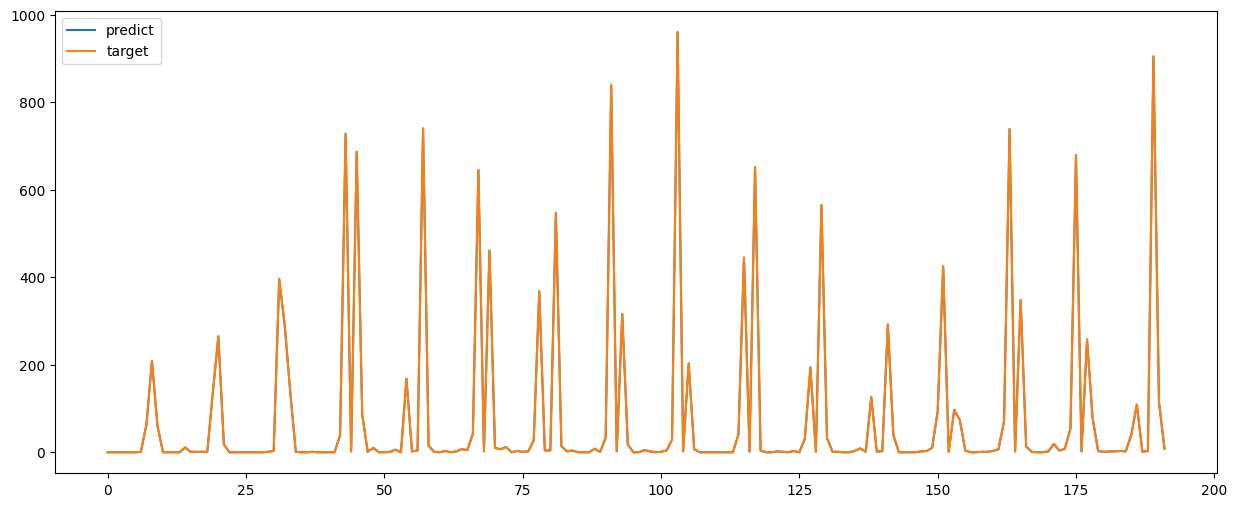

In [181]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [182]:
MSE(y_train_full, prev_train)

0.0

In [183]:
prev_test = modelo.predict(X_test)

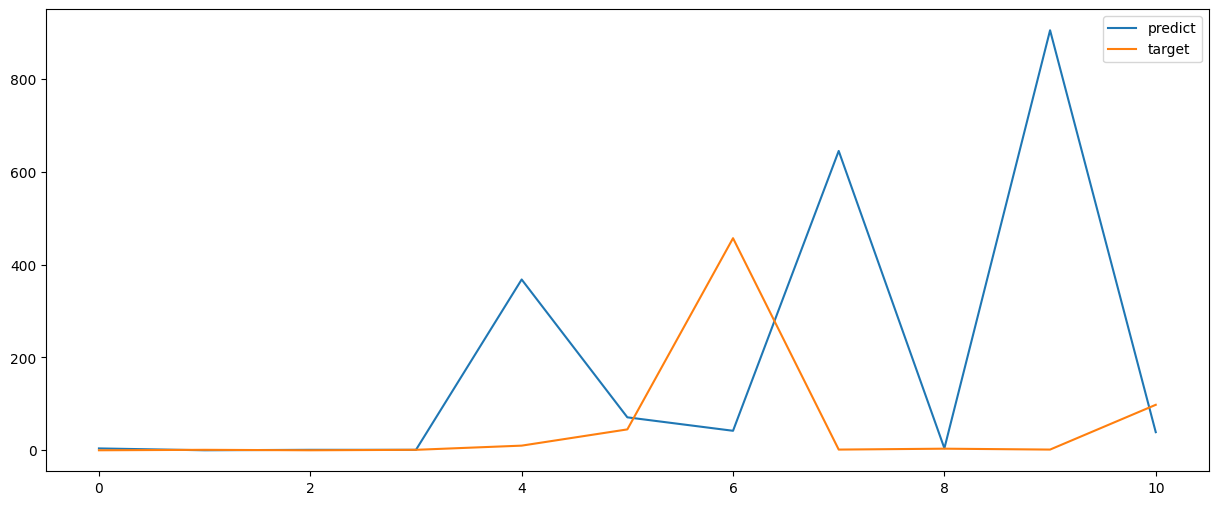

In [184]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [185]:
MSE(y_test, prev_test)

139542.15746263636

### Hyperparameters Tuning

In [186]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [2, 3, 4, 5, 6, 7, 8, 10, 15]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5]
ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004]

best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_ccp_alpha = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      for mss in min_samples_split:
        for msl in min_samples_leaf:
          for ccp_alpha in ccp_alphas:
            modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
            modelo.fit(X_train, y_train)
            prev_val = modelo.predict(X_val)

            mse = MSE(y_val, prev_val)
            if mse < best_mse:
              best_mse = mse
              best_criterion = c
              best_splitter = s
              best_depth = m
              best_min_samples_split = mss
              best_min_samples_leaf = msl
              best_ccp_alpha = ccp_alpha

In [187]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('absolute_error', 'random', 10, 2, 1, 0.002, 2497.16088775)

In [188]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [189]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

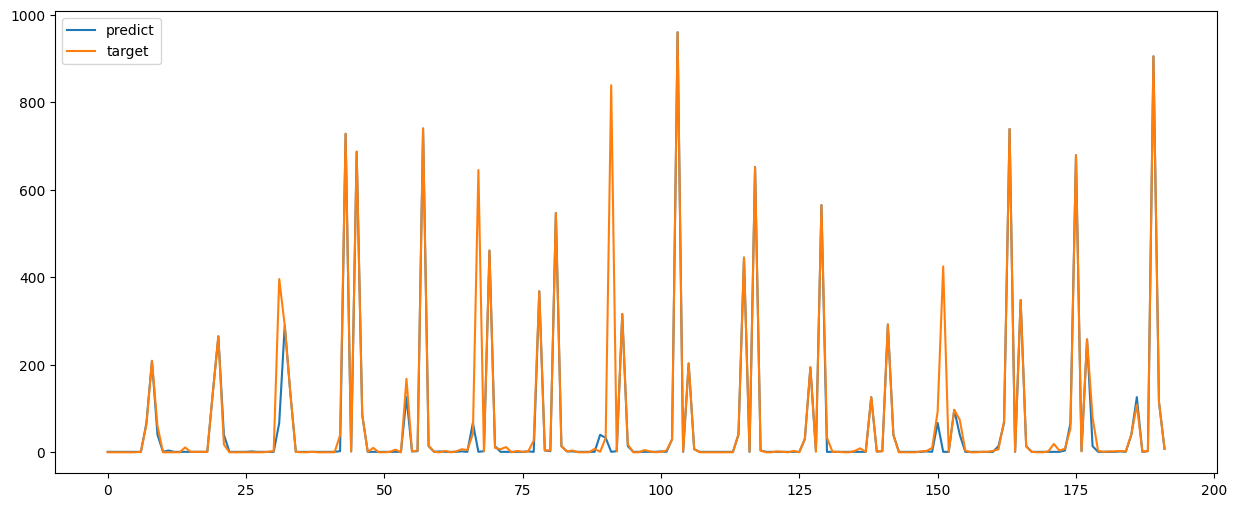

In [190]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [191]:
MSE(y_train_full, prev_train)

7398.781216057291

In [192]:
prev_test = modelo.predict(X_test)

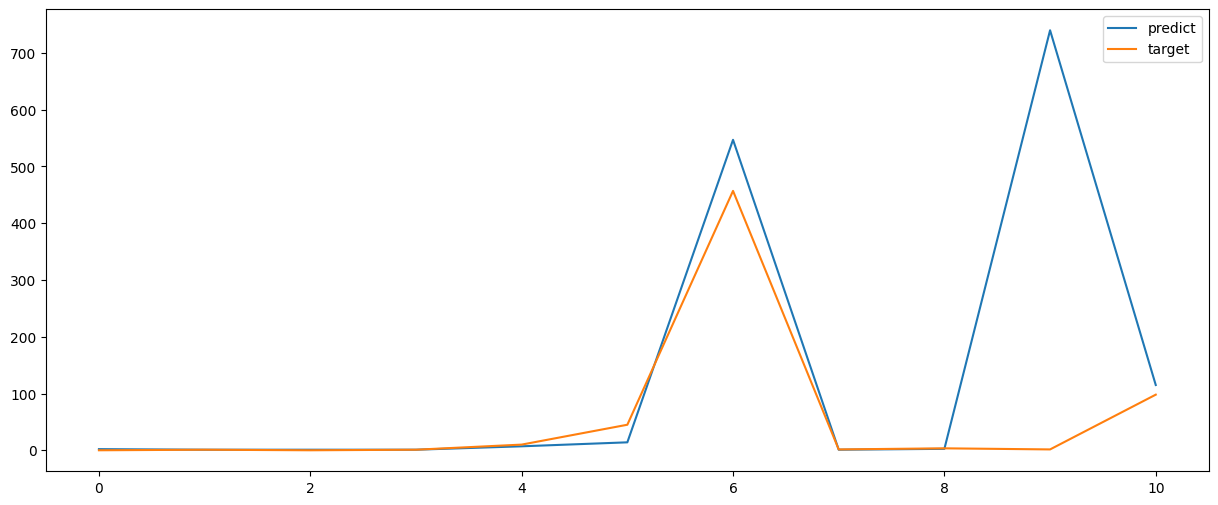

In [193]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [194]:
MSE(y_test, prev_test)

50430.498501545444

### Cross Time Validation

In [195]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('absolute_error', 'random', 10, 2, 1, 0.002, 2497.16088775)

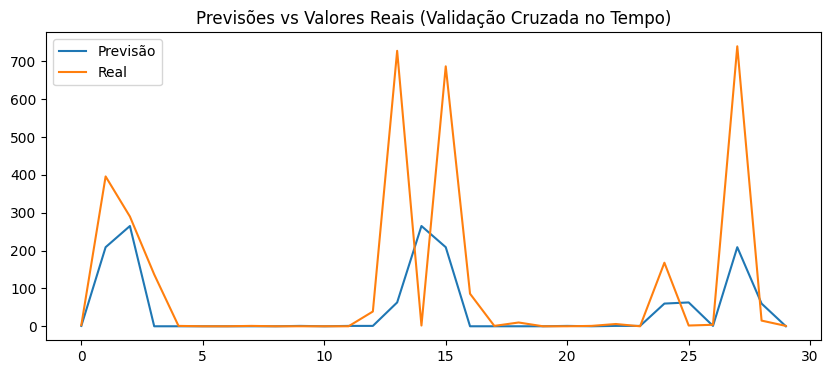

MSE da divisão: 36754.28041803334


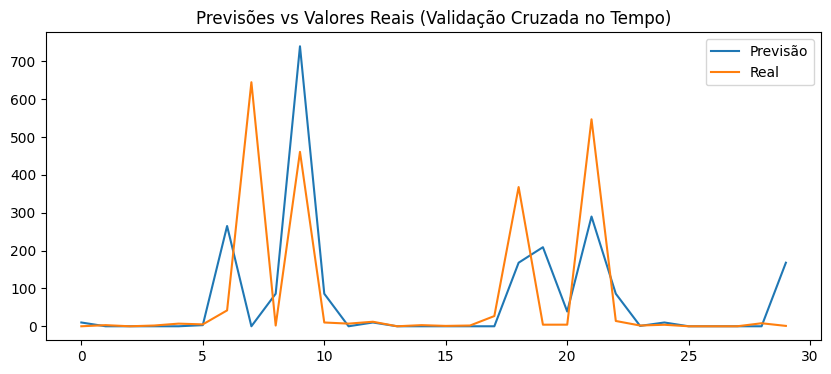

MSE da divisão: 24658.896989899997


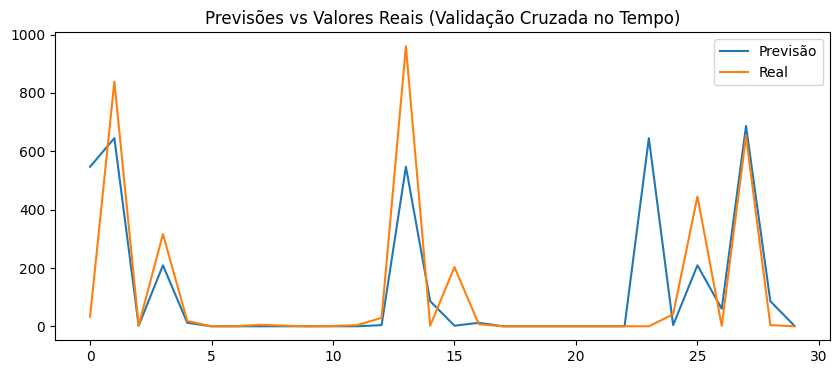

MSE da divisão: 33883.028358475


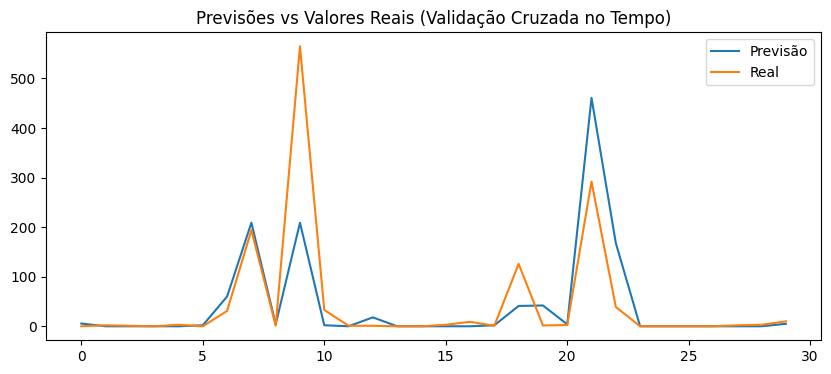

MSE da divisão: 6109.566492466667


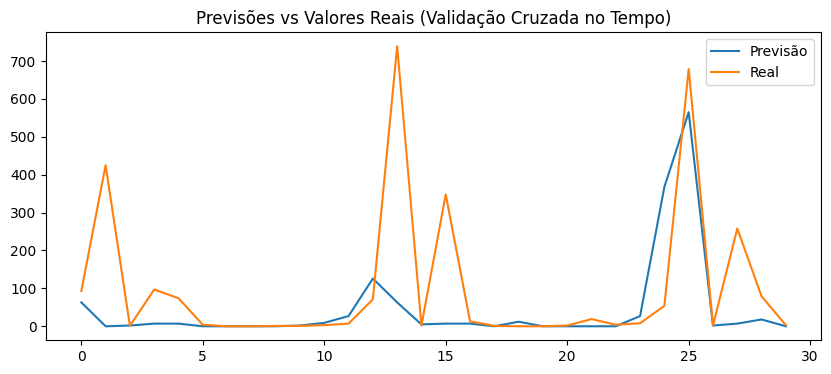

MSE da divisão: 31670.189204266666


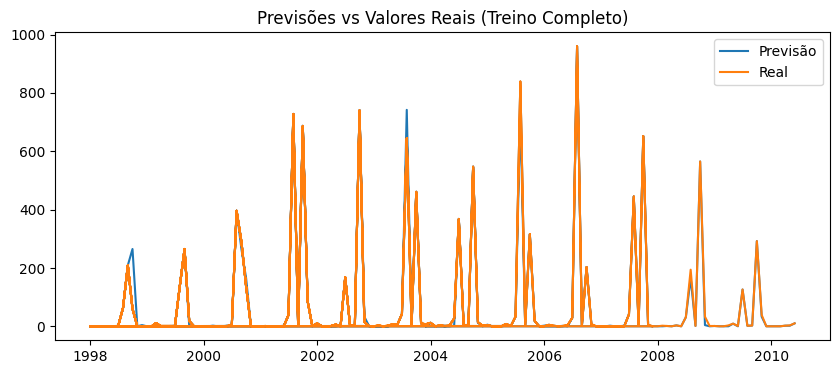

MSE do treino completo: 147.29639689555555


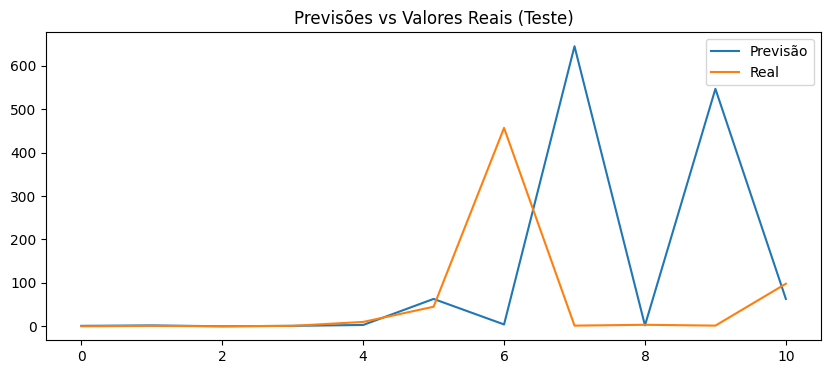

MSE do teste: 83481.31585072726


In [196]:
from sklearn.model_selection import TimeSeriesSplit

# Instanciando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Listas para armazenar os resultados das previsões e os índices
prev_train_full_all = []
y_train_full_all = []
dates_all = []

# Realizando a validação cruzada no tempo
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
    modelo.fit(X_train_fold, y_train_fold)
    prev_train_fold = modelo.predict(X_train_fold)
    prev_val_fold = modelo.predict(X_val_fold)
    
    prev_train_full_all.extend(prev_train_fold)
    y_train_full_all.extend(y_train_fold)
    dates_all.extend(train_fires.index[train_index])  # Ajuste conforme necessário
    
    # Plotando as previsões e os valores reais para cada divisão
    plt.figure(figsize=(10, 4))
    plt.plot(prev_val_fold, label='Previsão')
    plt.plot(y_val_fold, label='Real')
    plt.title('Previsões vs Valores Reais (Validação Cruzada no Tempo)')
    plt.legend(loc='best')
    plt.show()
    
    print(f'MSE da divisão: {MSE(y_val_fold, prev_val_fold)}')

# Convertendo os resultados em séries temporais
dates = pd.to_datetime(dates_all)
prev_train_series = pd.Series(prev_train_full_all, index=dates)
y_train_series = pd.Series(y_train_full_all, index=dates)

# Plotando as previsões finais para o conjunto de treino completo
plt.figure(figsize=(10, 4))
plt.plot(prev_train_series, label='Previsão')
plt.plot(y_train_series, label='Real')
plt.title('Previsões vs Valores Reais (Treino Completo)')
plt.legend(loc='best')
plt.show()

print(f'MSE do treino completo: {MSE(y_train_series, prev_train_series)}')

# Treinando o modelo final com todos os dados de treino e validação
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

modelo_final = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo_final.fit(X_train_full, y_train_full)

# Fazendo previsões com o modelo final no conjunto de teste
prev_test_final = modelo_final.predict(X_test)

# Plotando as previsões finais para o conjunto de teste
plt.figure(figsize=(10, 4))
plt.plot(prev_test_final, label='Previsão')
plt.plot(y_test, label='Real')
plt.title('Previsões vs Valores Reais (Teste)')
plt.legend(loc='best')
plt.show()

print(f'MSE do teste: {MSE(y_test, prev_test_final)}')


In [197]:
# from sklearn.model_selection import TimeSeriesSplit

# criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
# splitter = ['best', 'random']
# max_depths = [2, 3, 4, 5, 6, 7, 8, 10, 15]
# min_samples_split = [2, 3, 4, 5, 6]
# min_samples_leaf = [1, 2, 3, 4, 5]
# ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004]

# best_mse = np.inf
# best_criterion = None
# best_splitter = None
# best_depth = None
# best_min_samples_split = None
# best_min_samples_leaf = None
# best_ccp_alpha = None

# tscv = TimeSeriesSplit(n_splits=5)

# for train_index, val_index in tscv.split(X_train):
#     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

#     for c in criterion:
#         for s in splitter:
#             for m in max_depths:
#                 for mss in min_samples_split:
#                     for msl in min_samples_leaf:
#                         for ccp_alpha in ccp_alphas:
#                             modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
#                             modelo.fit(X_train_fold, y_train_fold)
#                             prev_val = modelo.predict(X_val_fold)

#                             mse = MSE(y_val_fold, prev_val)
#                             if mse < best_mse:
#                                 best_mse = mse
#                                 best_criterion = c
#                                 best_splitter = s
#                                 best_depth = m
#                                 best_min_samples_split = mss
#                                 best_min_samples_leaf = msl
#                                 best_ccp_alpha = ccp_alpha

# X_train_full = np.vstack([X_train, X_val])
# y_train_full = np.hstack([y_train, y_val])

# modelo_final = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
# modelo_final.fit(X_train_full, y_train_full)
# prev_train = modelo_final.predict(X_train_full)


In [198]:
# # Plotando as previsões para cada divisão da validação cruzada no tempo
# for train_index, val_index in tscv.split(X_train_full):
#     X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
#     y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
    
#     modelo_fold = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
#     modelo_fold.fit(X_train_fold, y_train_fold)
#     prev_val_fold = modelo_fold.predict(X_val_fold)
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(prev_val_fold, label='Previsão')
#     plt.plot(y_val_fold, label='Real')
#     plt.title('Previsões vs Valores Reais (Validação Cruzada no Tempo)')
#     plt.legend(loc='best')
#     plt.show()
    
#     print(f'MSE da divisão: {MSE(y_val_fold, prev_val_fold)}')

# # Treinando o modelo final com todos os dados de treino e validação
# modelo_final.fit(X_train_full, y_train_full)

# # Fazendo previsões com o modelo final no conjunto de treino completo
# prev_train_full = modelo_final.predict(X_train_full)

# # Plotando as previsões finais para o conjunto de treino completo
# plt.figure(figsize=(10, 4))
# plt.plot(prev_train_full, label='Previsão')
# plt.plot(y_train_full, label='Real')
# plt.title('Previsões vs Valores Reais (Treino Completo)')
# plt.legend(loc='best')
# plt.show()

# print(f'MSE do treino completo: {MSE(y_train_full, prev_train_full)}')

# # Fazendo previsões com o modelo final no conjunto de teste
# prev_test_final = modelo_final.predict(X_test)

# # Plotando as previsões finais para o conjunto de teste
# plt.figure(figsize=(10, 4))
# plt.plot(prev_test_final, label='Previsão')
# plt.plot(y_test, label='Real')
# plt.title('Previsões vs Valores Reais (Teste)')
# plt.legend(loc='best')
# plt.show()

# print(f'MSE do teste: {MSE(y_test, prev_test_final)}')


## MLPRegressor

In [199]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


identity sgd constant


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


identity sgd invscaling
identity sgd adaptive


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

In [200]:
(best_activation, best_solver, best_learning_rate, best_mse)

('tanh', 'lbfgs', 'adaptive', 12902.2102775511)

In [201]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [202]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


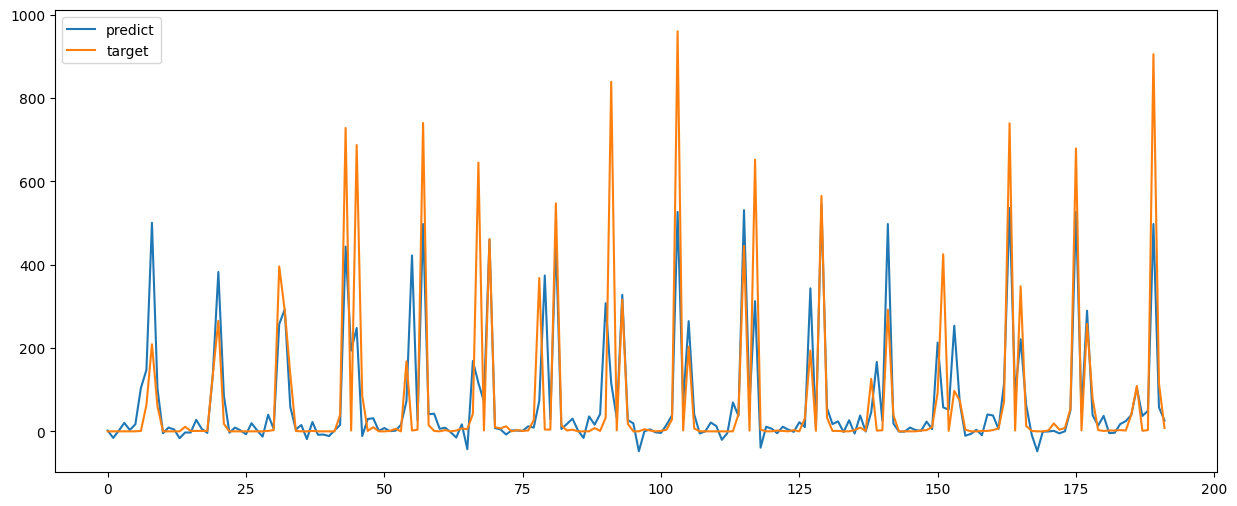

In [203]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [204]:
MSE(y_train_full, prev_train)

14358.912088045958

In [205]:
prev_test = modelo.predict(X_test)

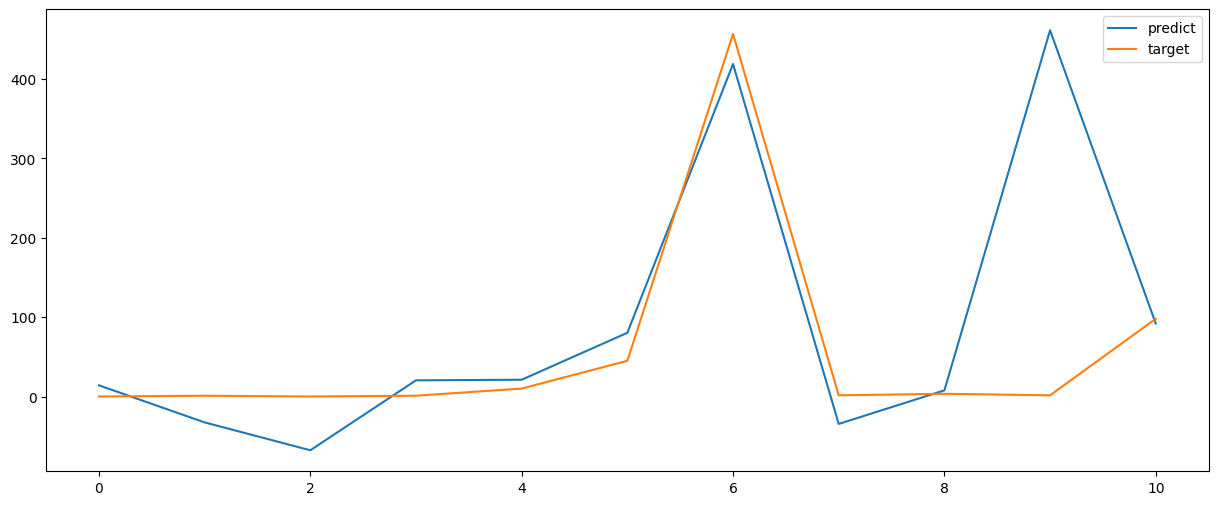

In [206]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [207]:
MSE(y_test, prev_test)

20194.60177656509

## KNeighborsRegressor

In [208]:
neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [1,2,3,4,5,10,15,20]

best_mse = np.inf
best_neighbors = None
best_weights = None
best_algorithm = None
best_leaf_size = None

for n in neighbors:
  for w in weights:
    for a in algorithm:
      for l in leaf_size:
        modelo = KNeighborsRegressor(n_neighbors=n, weights=w, algorithm=a, leaf_size=l)
        modelo.fit(X_train, y_train)
        prev_val = modelo.predict(X_val)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_neighbors = n
            best_weights = w
            best_algorithm = a
            best_leaf_size = l

In [209]:
(best_neighbors, best_weights, best_algorithm, best_leaf_size, best_mse)

(7, 'uniform', 'auto', 1, 22032.34045277211)

In [210]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [211]:
modelo = KNeighborsRegressor(n_neighbors=best_neighbors, weights=best_weights, algorithm=best_algorithm, leaf_size=best_leaf_size)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

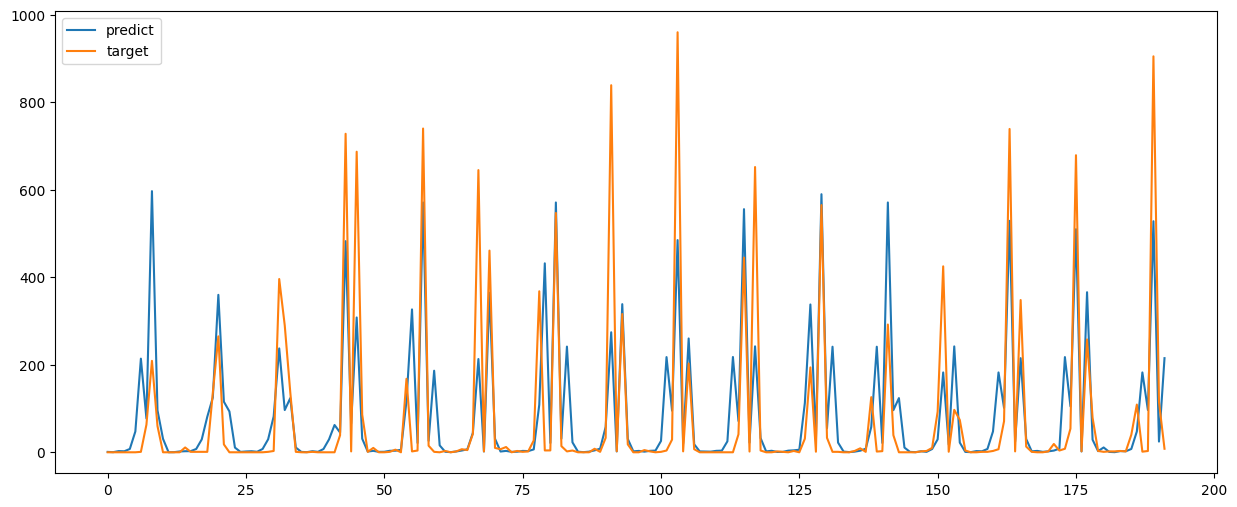

In [212]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [213]:
MSE(y_train_full, prev_train)

14521.362646506059

In [214]:
prev_test = modelo.predict(X_test)

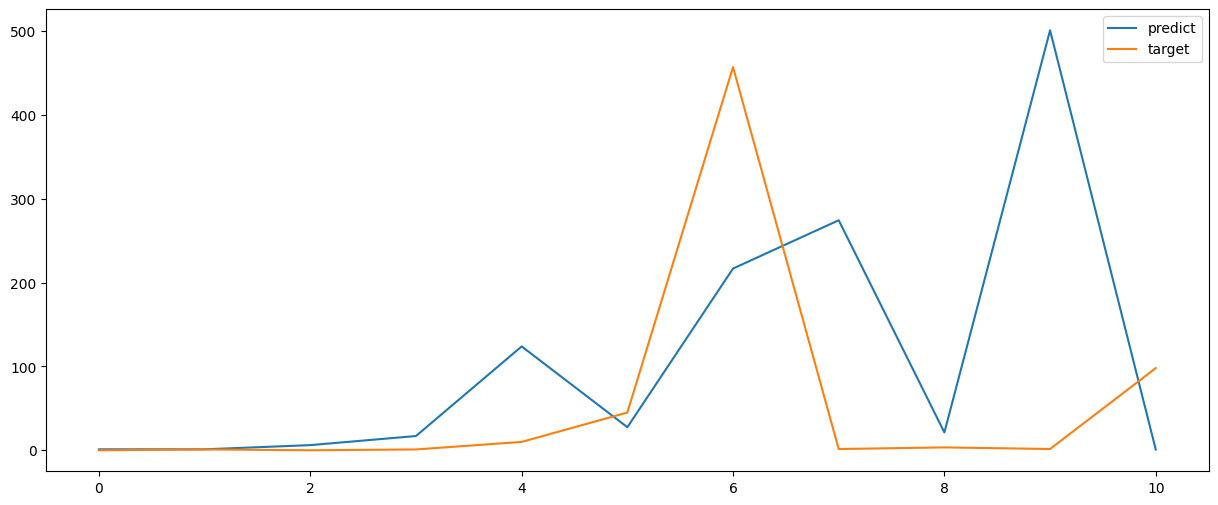

In [215]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [216]:
MSE(y_test, prev_test)

36802.60021992022

# Series Matlab

In [217]:
series_matlab

,month,matlab
0,2009-01-31,19
1,2009-02-28,27
2,2009-03-31,24
3,2009-04-30,32
4,2009-05-31,42
...,...,...
127,2019-08-31,371
128,2019-09-30,362
129,2019-10-31,523
130,2019-11-30,479


In [219]:
series_matlab['month'] = pd.to_datetime(series_matlab['month'])

In [220]:
series_matlab = series_matlab.set_index('month')

<Axes: xlabel='month'>

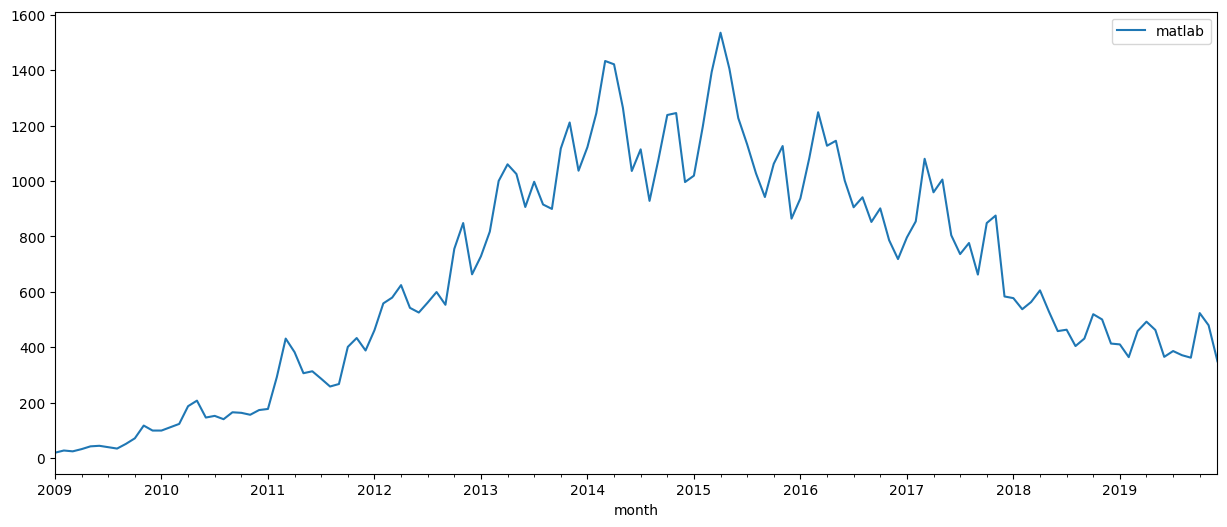

In [221]:
series_matlab.plot()

In [241]:
train_matlab, val_matlab, test_matlab = series_matlab.loc['2009':'2016'], series_matlab.loc['2017'], series_matlab.loc['2018':'2019']

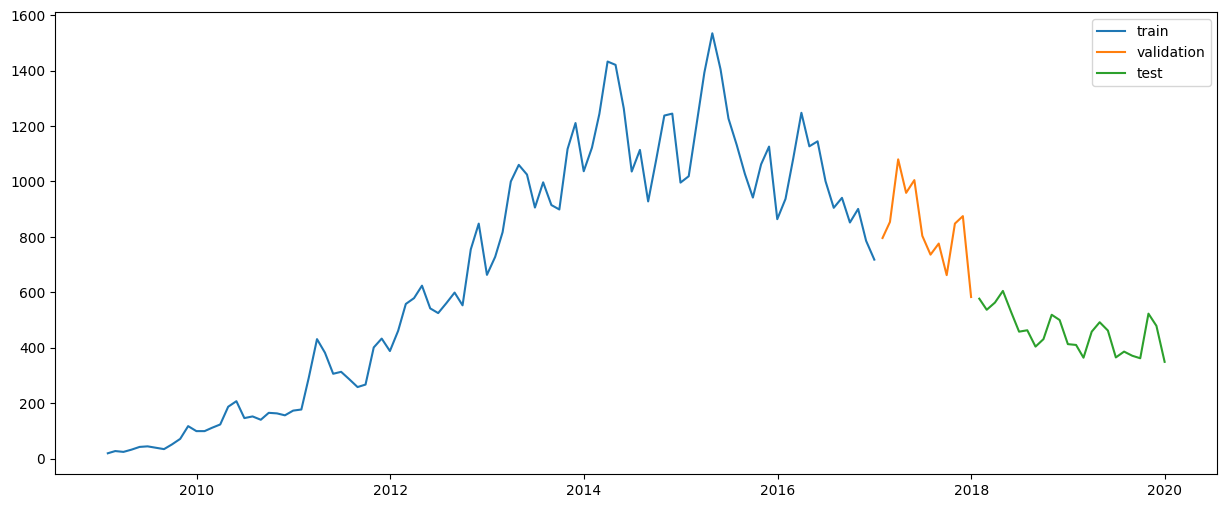

In [242]:
plt.plot(train_matlab, label = 'train')
plt.plot(val_matlab, label = 'validation')
plt.plot(test_matlab, label = 'test')
plt.legend(loc = 'best')
plt.show()

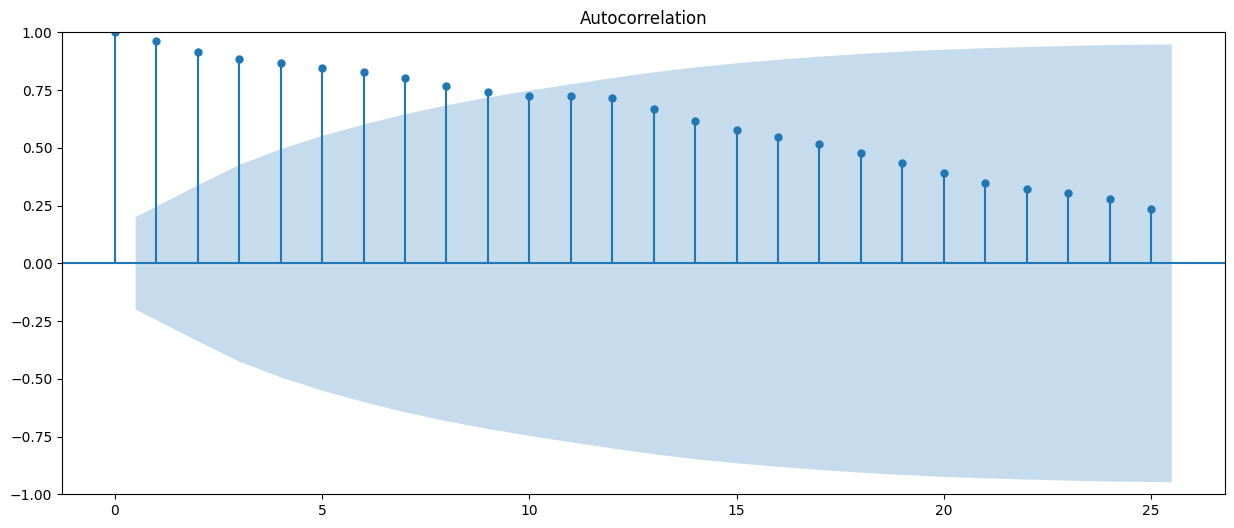

In [243]:
sm.graphics.tsa.plot_acf(train_matlab, lags=25)
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


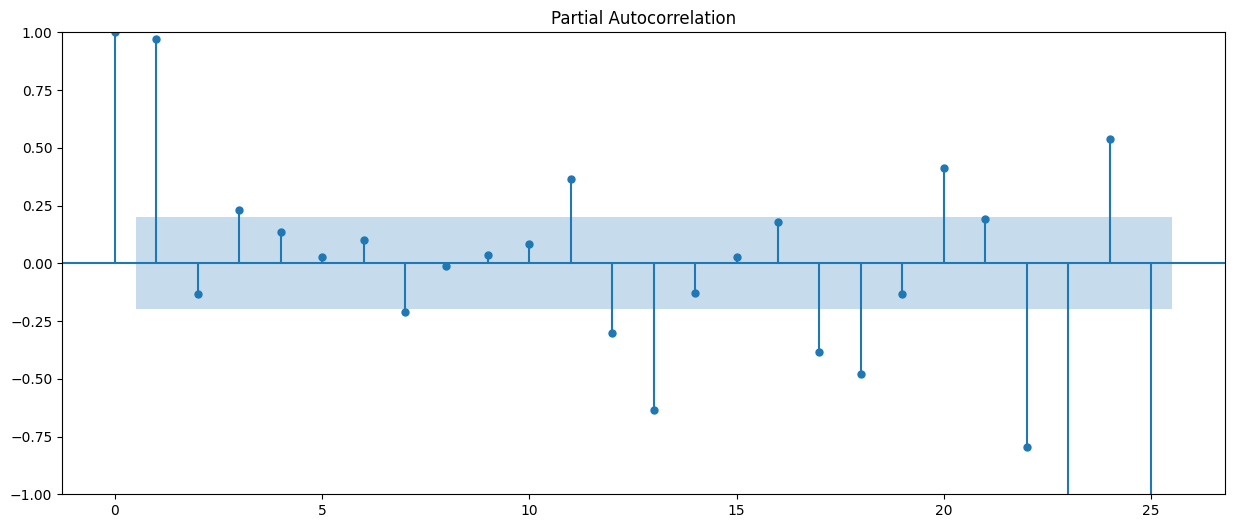

In [244]:
fig = sm.graphics.tsa.plot_pacf(train_matlab, lags=25)
plt.show()

In [245]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [246]:
train_windows = create_sliding_windows(train_matlab, 9)
val_windows = create_sliding_windows(val_matlab, 9)
test_windows = create_sliding_windows(test_matlab, 9)

In [247]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1]

## Decision Tree Regressor

In [248]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']


best_mse = np.inf
best_criterion = None
best_splitter = None

for c in criterion:
  for s in splitter:
    modelo = DecisionTreeRegressor(criterion=c, splitter=s)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse = MSE(y_val, prev_val)
    if mse < best_mse:
        best_mse = mse
        best_criterion = c
        best_splitter = s

In [249]:
(best_criterion, best_splitter, best_mse)

('friedman_mse', 'random', 14898.0)

In [250]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [251]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

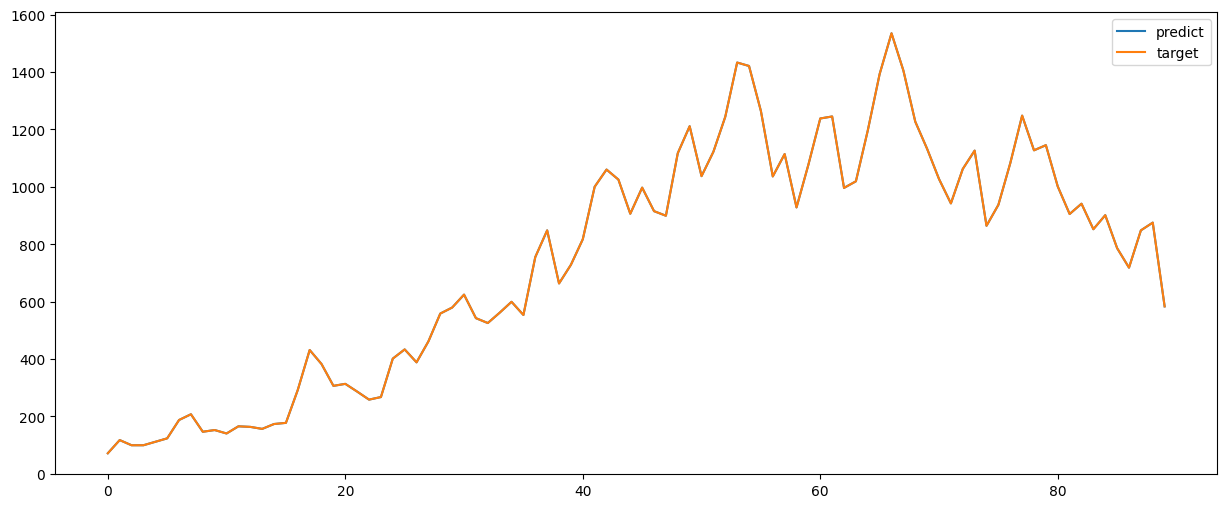

In [252]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [253]:
MSE(y_train_full, prev_train)

0.0

In [254]:
prev_test = modelo.predict(X_test)

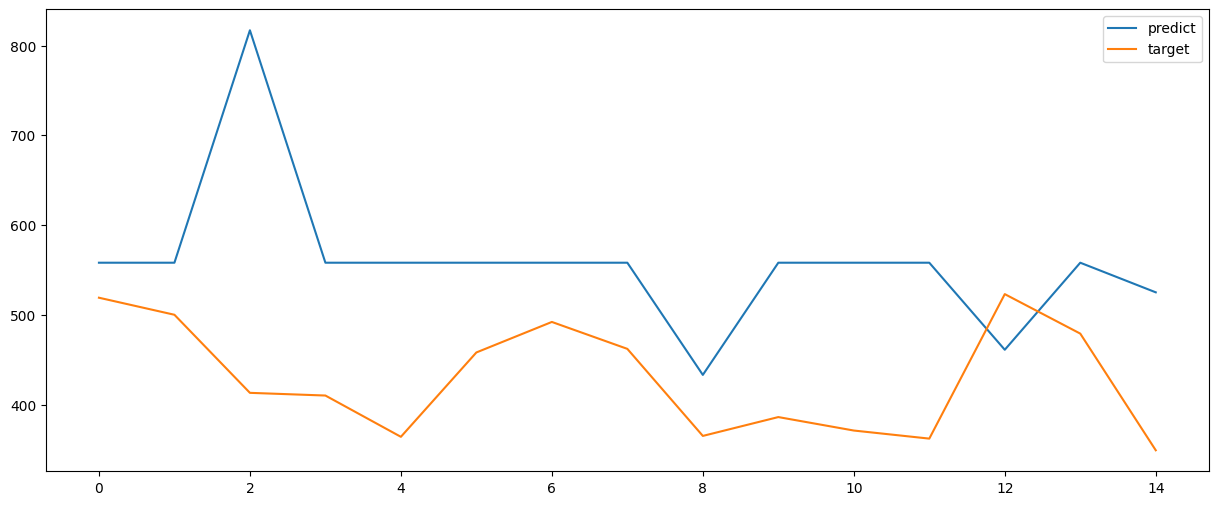

In [255]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [256]:
MSE(y_test, prev_test)

26657.8

### Hyperparameter Tuning

In [257]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depths = [2, 3, 4, 5, 6, 7, 8, 10, 15]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5]
ccp_alphas = [0.0, 0.001, 0.002, 0.003, 0.004]

best_mse = np.inf
best_criterion = None
best_splitter = None
best_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_ccp_alpha = None

for c in criterion:
  for s in splitter:
    for m in max_depths:
      for mss in min_samples_split:
        for msl in min_samples_leaf:
          for ccp_alpha in ccp_alphas:
            modelo = DecisionTreeRegressor(criterion=c, splitter=s, max_depth=m, min_samples_split=mss, min_samples_leaf=msl, ccp_alpha=ccp_alpha)
            modelo.fit(X_train, y_train)
            prev_val = modelo.predict(X_val)

            mse = MSE(y_val, prev_val)
            if mse < best_mse:
              best_mse = mse
              best_criterion = c
              best_splitter = s
              best_depth = m
              best_min_samples_split = mss
              best_min_samples_leaf = msl
              best_ccp_alpha = ccp_alpha

In [258]:
(best_criterion, best_splitter, best_depth, best_min_samples_split, best_min_samples_leaf, best_ccp_alpha, best_mse)

('poisson', 'random', 15, 3, 5, 0.001, 935.0431490004145)

In [259]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [260]:
modelo = DecisionTreeRegressor(criterion=best_criterion, splitter=best_splitter, max_depth=best_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, ccp_alpha=best_ccp_alpha)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

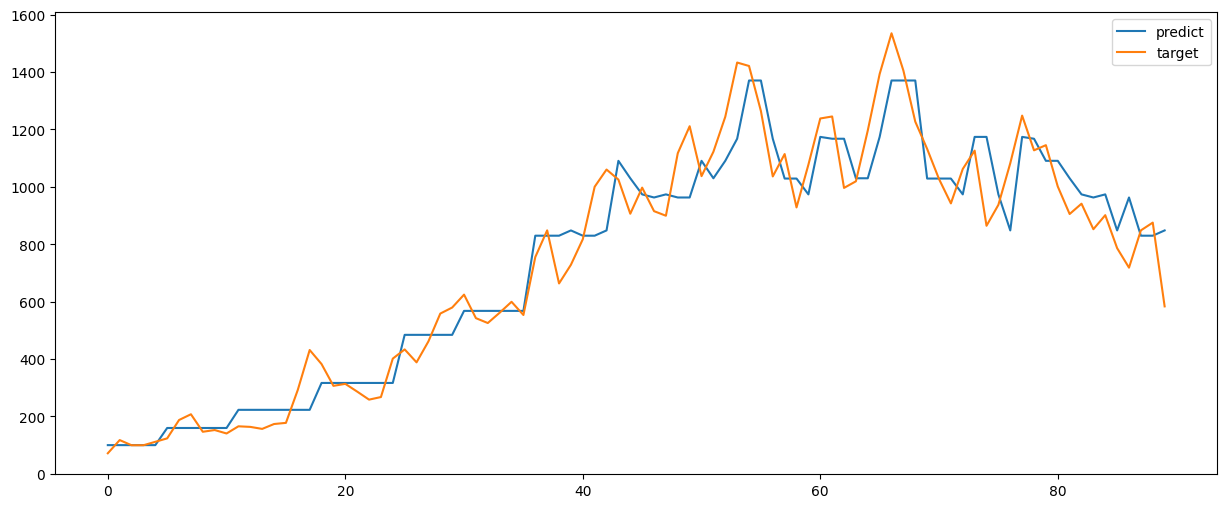

In [261]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [262]:
MSE(y_train_full, prev_train)

11732.67740740741

In [263]:
prev_test = modelo.predict(X_test)

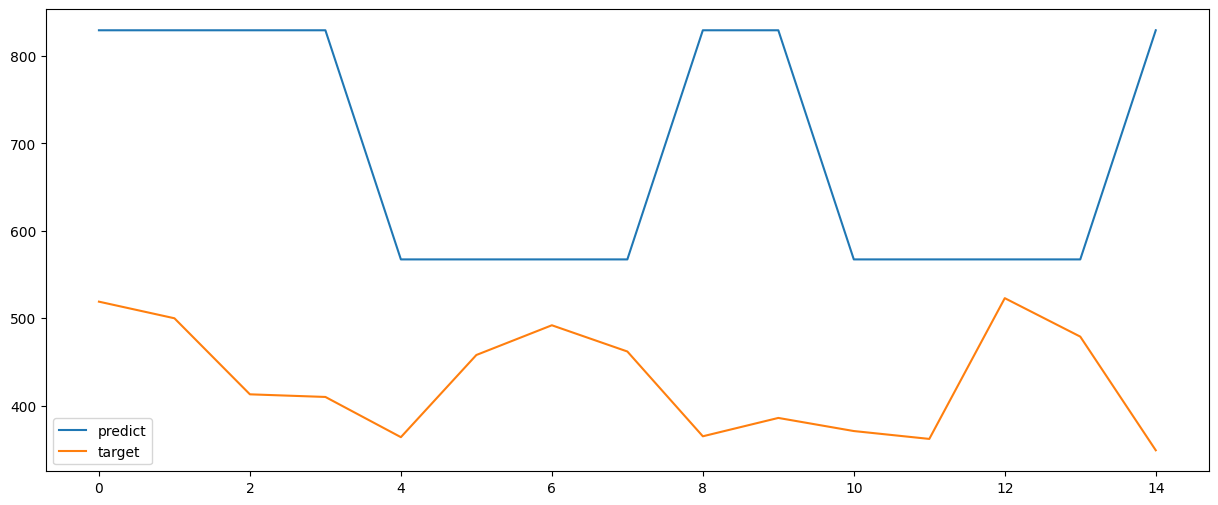

In [264]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [265]:
MSE(y_test, prev_test)

90526.78624338626

### Cross Time Validation

## MLPRegressor

In [ ]:
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

best_mse = np.inf
best_activation = None
best_solver = None
best_learning_rate = None

for a in activation:
  for s in solver:
    for l in learning_rate:
        try:
           
          modelo = MLPRegressor(activation=a, solver=s, learning_rate=l)
          modelo.fit(X_train, y_train)
          prev_val = modelo.predict(X_val)
        
        except:
           print(a,s,l)

        mse = MSE(y_val, prev_val)
        if mse < best_mse:
            best_mse = mse
            best_activation = a
            best_solver = s
            best_learning_rate = l

In [267]:
(best_activation, best_solver, best_learning_rate, best_mse)

('relu', 'lbfgs', 'invscaling', 12872.502902185273)

In [268]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [269]:
modelo = MLPRegressor(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate)
modelo.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


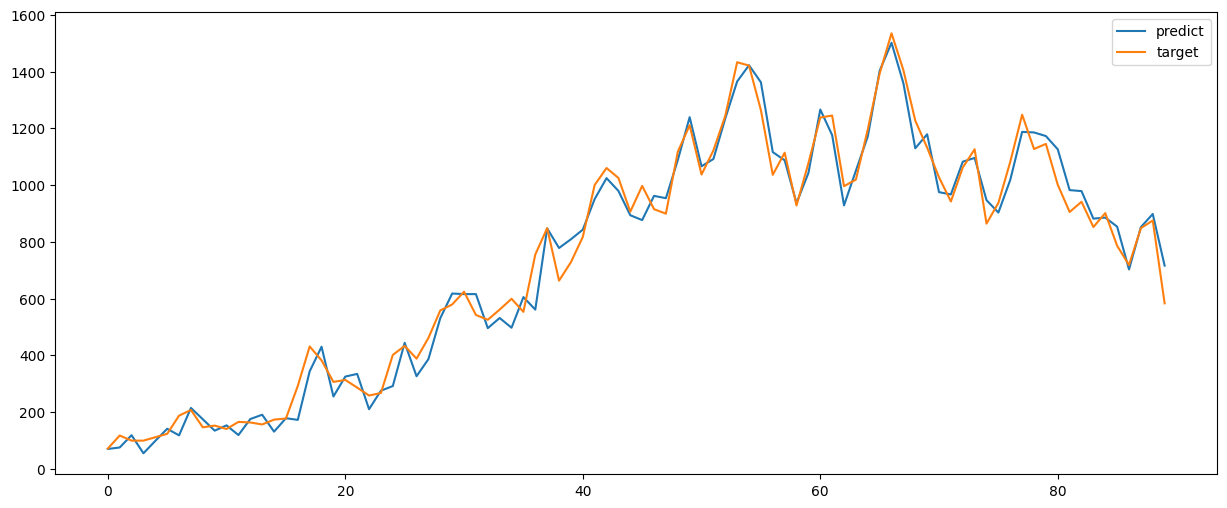

In [270]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [271]:
MSE(y_train_full, prev_train)

3338.0054367870657

In [272]:
prev_test = modelo.predict(X_test)

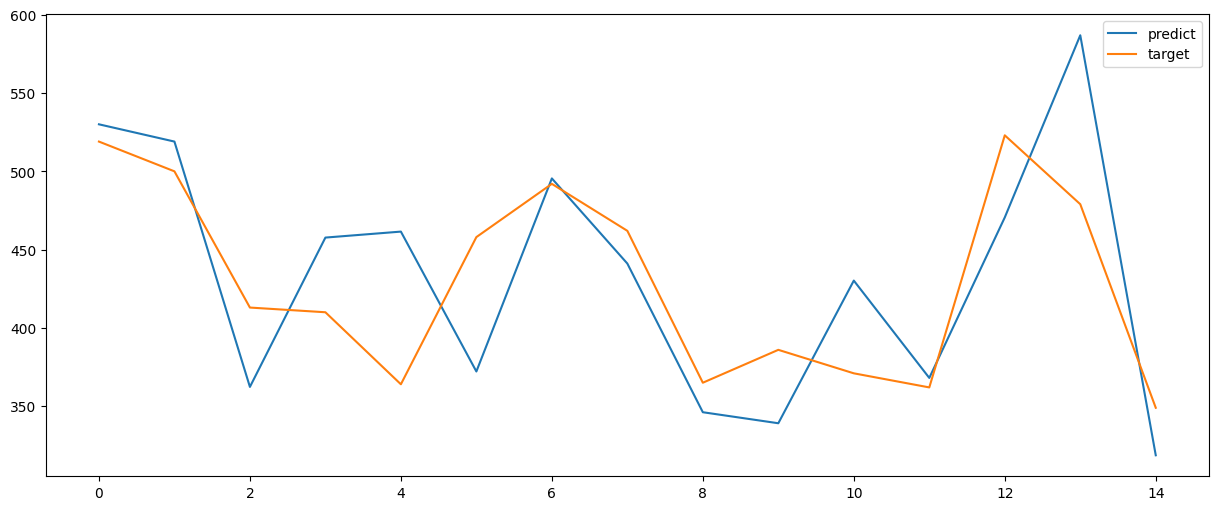

In [273]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [274]:
MSE(y_test, prev_test)

2936.97089179793